In [1]:
import numpy as np
import scipy.io
import xarray as xr
import os
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw

from data_loading import get_altimetry_data, get_2021_CTD_data

## Choosing the section

/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code MOCIS/FOET/FOET_Northern_Gyre/data_loading.py:70: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.Dataset(
/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code MOCIS/FOET/FOET_Northern_Gyre/data_loading.py:70: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond

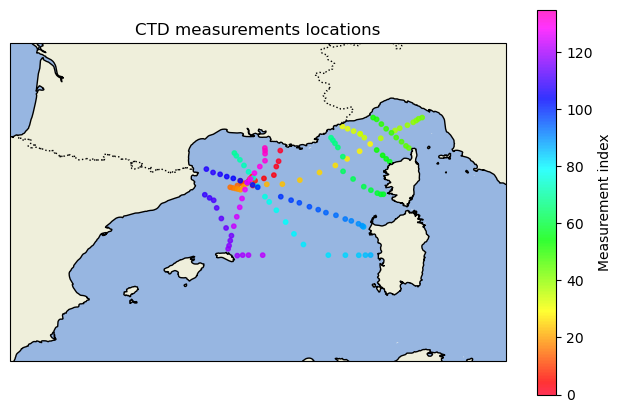

In [2]:
ds = get_2021_CTD_data()

# Map of measurements locations
fig, ax = plt.subplots(figsize=(8,5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
sc = ax.scatter(ds.lat, ds.lon, s=10, c=ds.idx, cmap='gist_rainbow', alpha=0.8)
plt.colorbar(sc, ax=ax, label='Measurement index')
plt.title('CTD measurements locations')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


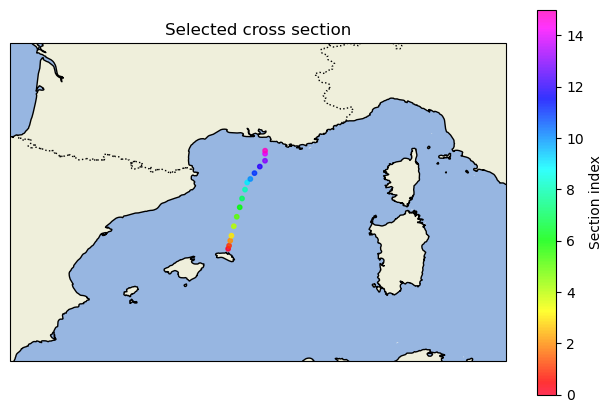

In [3]:
selected_idxs = list(range(115, ds.idx.max().values))
selected_idxs.remove(122)
selected_idxs.remove(121)
selected_idxs.remove(120)
selected_idxs.remove(119)

section_ds = ds.sel(idx=selected_idxs)

# Ordering by increasing latitude
section_ds = section_ds.sortby('lat')
section_ds['section_idx'] = np.arange(len(section_ds.lat))

# Map of measurements locations
fig, ax = plt.subplots(figsize=(8,5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
sc = ax.scatter(section_ds.lat, section_ds.lon, s=10, c=section_ds.section_idx, alpha=0.8, cmap='gist_rainbow')
plt.colorbar(sc, ax=ax, label='Section index')
plt.title('Selected cross section')
plt.show()


## Profiles


In [4]:
section_ds['density'] = gsw.rho_t_exact(section_ds.salinity, section_ds.temperature, section_ds.pressure)
D = section_ds['density'].values
min_density = np.nanmin(D)
max_density = np.nanmax(D)


### Temperature profile

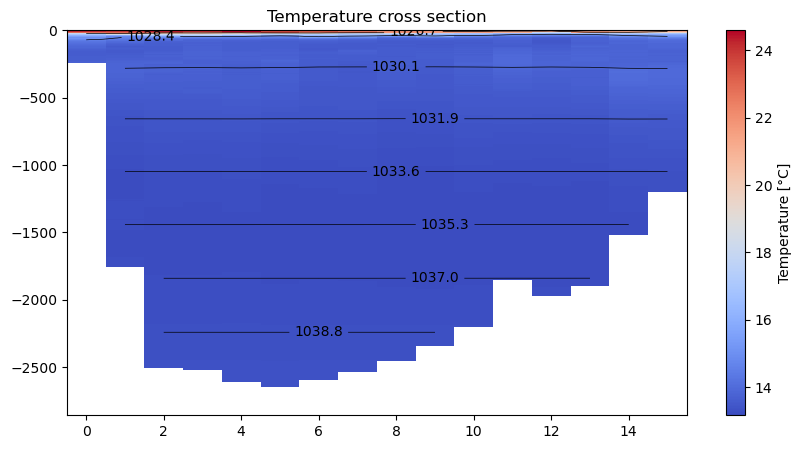

In [5]:
# T cross section plot
X = section_ds['temperature'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    section_ds.section_idx, 
    section_ds.depth, 
    X.T, 
    cmap='coolwarm'
)
plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
cont = ax.contour(
    section_ds.section_idx, 
    section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.title('Temperature cross section')
plt.show()

### Salinity profile

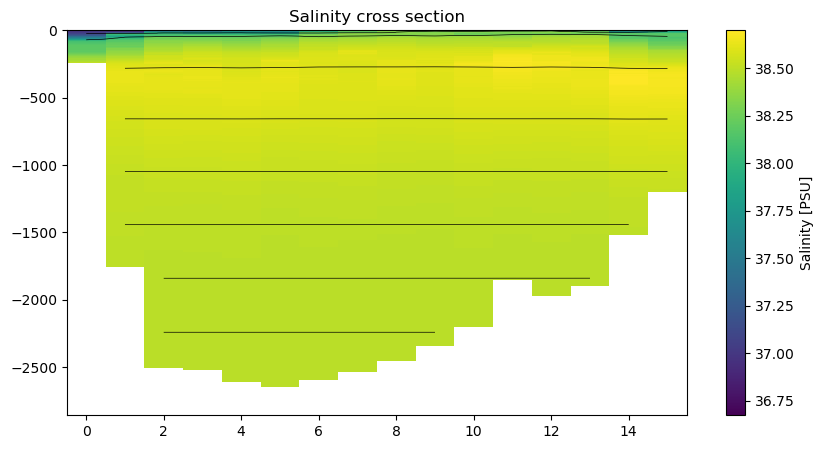

In [6]:
# S cross section plot
S = section_ds['salinity'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(section_ds.section_idx, section_ds.depth, S.T, cmap='viridis')
plt.colorbar(cmesh, ax=ax, label='Salinity [PSU]')
cont = ax.contour(
    section_ds.section_idx, 
    section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.title('Salinity cross section')
plt.show()

### Density profile

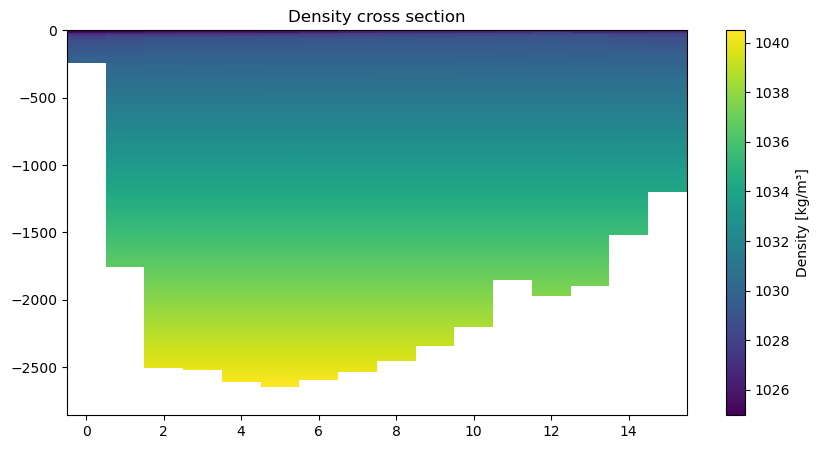

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(section_ds.section_idx, section_ds.depth, D.T, cmap='viridis')
plt.colorbar(cmesh, ax=ax, label='Density [kg/m³]')
plt.title('Density cross section')
plt.show()

### Zoom on surface layers

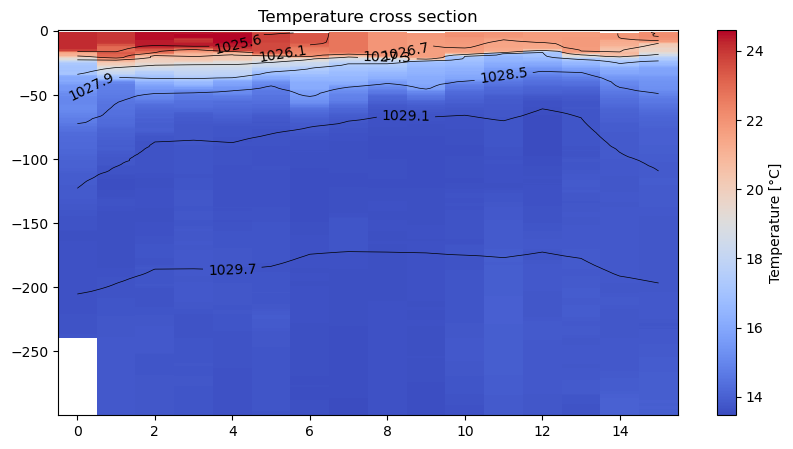

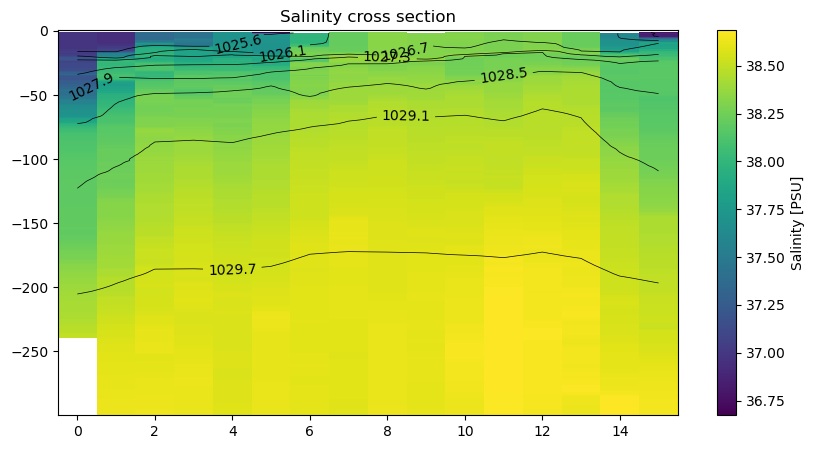

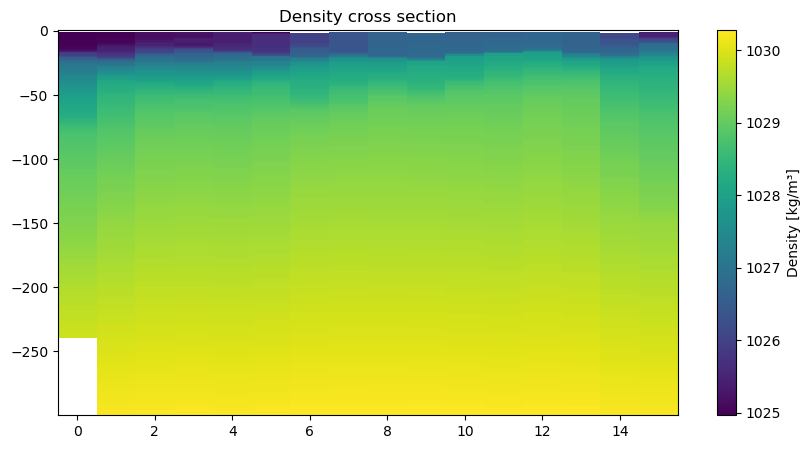

In [12]:
max_depth = 300

serface_section_ds = section_ds.where(-section_ds.depth <= max_depth, drop=True)

D = serface_section_ds['density'].values
min_density = np.nanmin(D)
max_density = np.nanmax(D)

# T cross section plot
X = serface_section_ds['temperature'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    serface_section_ds.section_idx, 
    serface_section_ds.depth, 
    X.T, 
    cmap='coolwarm'
)
plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
cont = ax.contour(
    serface_section_ds.section_idx, 
    serface_section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.title('Temperature cross section')
plt.show()

# S cross section plot
S = serface_section_ds['salinity'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(serface_section_ds.section_idx, serface_section_ds.depth, S.T, cmap='viridis')
plt.colorbar(cmesh, ax=ax, label='Salinity [PSU]')
cont = ax.contour(
    serface_section_ds.section_idx, 
    serface_section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.title('Salinity cross section')
plt.show()

# D cross section plot

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(serface_section_ds.section_idx, serface_section_ds.depth, D.T, cmap='viridis')
plt.colorbar(cmesh, ax=ax, label='Density [kg/m³]')
plt.title('Density cross section')
plt.show()
